# Cluster analyses of the image embeddings

In this notebook we aim at analyzing the structure of the inferred image embeddings and associated gene perturbation embeddings and compare it to the structure observed in related data sets like the morphological profiles of Rohban et al. (2017) and related gene signatures from the CMap data set.

---

## 0. Environmental setup

First, we setup the environment by loading required packages.

In [1]:
import pandas as pd
import numpy as np
from venn import venn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from cmapPy.pandasGEXpress.parse import parse
from scipy.spatial.distance import squareform, pdist
import matplotlib as mpl
import os

import sys
from yellowbrick.cluster import KElbowVisualizer

sys.path.append("../../..")
from src.utils.notebooks.ppi.embedding import plot_tsne_embs
from src.utils.notebooks.images.embedding import *
from src.utils.torch.network import *
from src.utils.notebooks.ppi.embedding import *

mpl.rcParams["figure.dpi"] = 600

2024-11-20 09:29:00.439881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def run_cc_test(cluster_sol1, cluster_sol2, b=1000, score="mi", random_state=1234):
    np.random.seed(random_state)
    cc_score = compute_cc_score(cluster_sol1, cluster_sol2, score=score)
    perm_cc_scores = []
    for i in tqdm(range(b)):
        cluster_sol1_perm = np.random.permutation(cluster_sol1)
        cluster_sol2_perm = np.random.permutation(cluster_sol2)
        perm_cc_score = compute_cc_score(
            cluster_sol1_perm, cluster_sol2_perm, score=score
        )
        perm_cc_scores.append(perm_cc_score)
    perm_cc_scores = np.array(perm_cc_scores)
    return {
        "cc_score": cc_score,
        "perm_cc_scores": perm_cc_scores,
        "pval": np.mean(perm_cc_scores >= (cc_score - 1e-8), axis=0),
    }

---

## 1. Read in data

Next, we read in all the required data sets. This first consists of the image embeddings derived from the chromatin image inputs. For the analysis, we randomly choose the embeddings obtained from the first fold of the applied 4-fold cross-validation approach when inferring the image embeddings. To not bias our analyses we will use the test set embeddings obtained from the respecitvely trained convolutional neureal network. Note that this is selection is consistent with the previous analysis e.g. when visualizing the inferred image embeddings.

In [4]:
root_dir = "/data/xinyi/image2reg/data_new/experiments/jump/images/embedding/specificity_target_emb_cv_strat/"

physical_space_embs = pd.read_hdf(
    os.path.join(root_dir,'fold_2/20241025_121428','test_latents.h5')
)

compoundgenes=np.array(['APPBP2', 'AQP1', 'AURKA', 'AURKB', 'BIRC5', 'CCNA2', 'CDK1',
                        'CDK2', 'CDK6', 'DMSO', 'EEF1A2', 'FGF1', 'FGFR2', 'FGFR3',
                        'GABRB3', 'GSK3B', 'LGALS1', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MAPK8',
                        'PARP2', 'PCNA', 'PDGFRB', 'PLAT', 'PRKACA', 'RARA', 'THRA', 'TK1',
                        'TLR4', 'TNNC1'])

spec_results = pd.read_csv(
    "/data/xinyi/image2reg/data_new/experiments/jump/images/screen/nuclei_region/specificity_screen_results_cv.csv",
    index_col=0,
)
spec_results = spec_results.loc[spec_results["selected"]]
spec_orf_targets = set(spec_results.index)
target_list = sorted([i for i in list(spec_orf_targets) + ["NC"] if i not in compoundgenes])
label_dict={}
for i in range(len(target_list)):
    label_dict[target_list[i]]=i

label_dict = dict(zip(list(label_dict.values()), list(label_dict.keys())))
physical_space_embs.loc[:, "labels"] = np.array(
    physical_space_embs.labels.map(label_dict)
)
mean_physical_space_embs = physical_space_embs.groupby("labels").mean()

oe_targets = set(mean_physical_space_embs.index) - {"NC"}

In [5]:
def load_and_preprocess_morphological_profiles(profile_file, md_file, save=True):
    morph_profiles = pd.read_csv(profile_file)
    image_metadata = pd.read_csv(md_file, index_col=0)
    image_numbers = morph_profiles.loc[:, "ImageNumber"]
    labels = image_numbers.map(
    dict(
        zip(
            list(image_metadata.loc[:, "ImageNumber"]),
            list(image_metadata.loc[:, "Image_Metadata_GeneSymbol"]),
        )
    )
)
    drop_columns = ["Nuclei_Number_Object_Number"]
    for col in morph_profiles.columns:
        if "ERSyto" in col:
            drop_columns.append(col)
        elif "Mito" in col:
            drop_columns.append(col)
        elif "PhGolgi" in col:
            drop_columns.append(col)
    
    morph_profiles = morph_profiles.loc[morph_profiles.ImageNumber.isin(image_metadata.ImageNumber.unique())]
    morph_profiles = morph_profiles.drop(drop_columns, axis=1)
    morph_profiles["labels"] = labels
    # Drop invariant columns and remove NaN rows
    morph_profiles = morph_profiles.loc[
    :, (morph_profiles != morph_profiles.iloc[0]).any()
]
    morph_profiles = morph_profiles.dropna()
    if save:
        os.makedirs("/data/xinyi/image2reg/data_new/resources/images/jump/profiles")
        morph_profiles.to_csv("/data/xinyi/image2reg/data_new/resources/images/jump/profiles/nuclei_profiles_hoechst_cleaned.csv")
    return morph_profiles, image_metadata


Note that we identify the gene perturbation embeddings as the mean of the image embeddings corresponding to a given gene perturbation setting.

Next, we load the preprocessed CMAP data set.

In [6]:
mean_cmap_sigs = pd.read_csv(
    "/data/xinyi/image2reg/data_pretrained/data_for_xinyi/embeddings/cmap_signatures.csv",
    index_col=0,
)

Finally, we load the morphological profiles that were derived for the same data set by Rohban et al. (2017). Note that we have already removed all features that do not correspond to the data available from the Hoechst stained channels as the physical space embeddings are also solely use information obtained from the Hoechst stained images.

In [6]:
# _, image_metadata = load_and_preprocess_morphological_profiles(profile_file="/data/xinyi/image2reg/data_new/resources/images/jump/metadata/nuclei_morph_profiles.csv", md_file = "../../../../data/experiments/rohban/images/preprocessing/full_pipeline/filtered_image_metadata.csv")



To uniquely represent each target by a corresponding gene signature, morphological profile or image embeddings we will consider the means of all related embeddings.

---

## 3. Clustering of the different signatures and embeddings

Having preprocessed the individual descriptions of the response of cells to the overexpression conditions, we will now assess the structure of the correspondly spanned latent spaces. To this end, we will hierarchically cluster all embeddings using euclidean distances for the physical space embeddings and morphological profiles and cosine distances for the CMAP gene signatures. Complete linkage is chosen for all clusterings to obtain compact clusters and the optimal number of clusters is determined by looking at the Silhouette and Calisnki-Harabasz score for cluster cutoffs in [2,15].

### 3.a. Clustering of the gene perturbation embeddings.

We start with the clustering of the physical space.

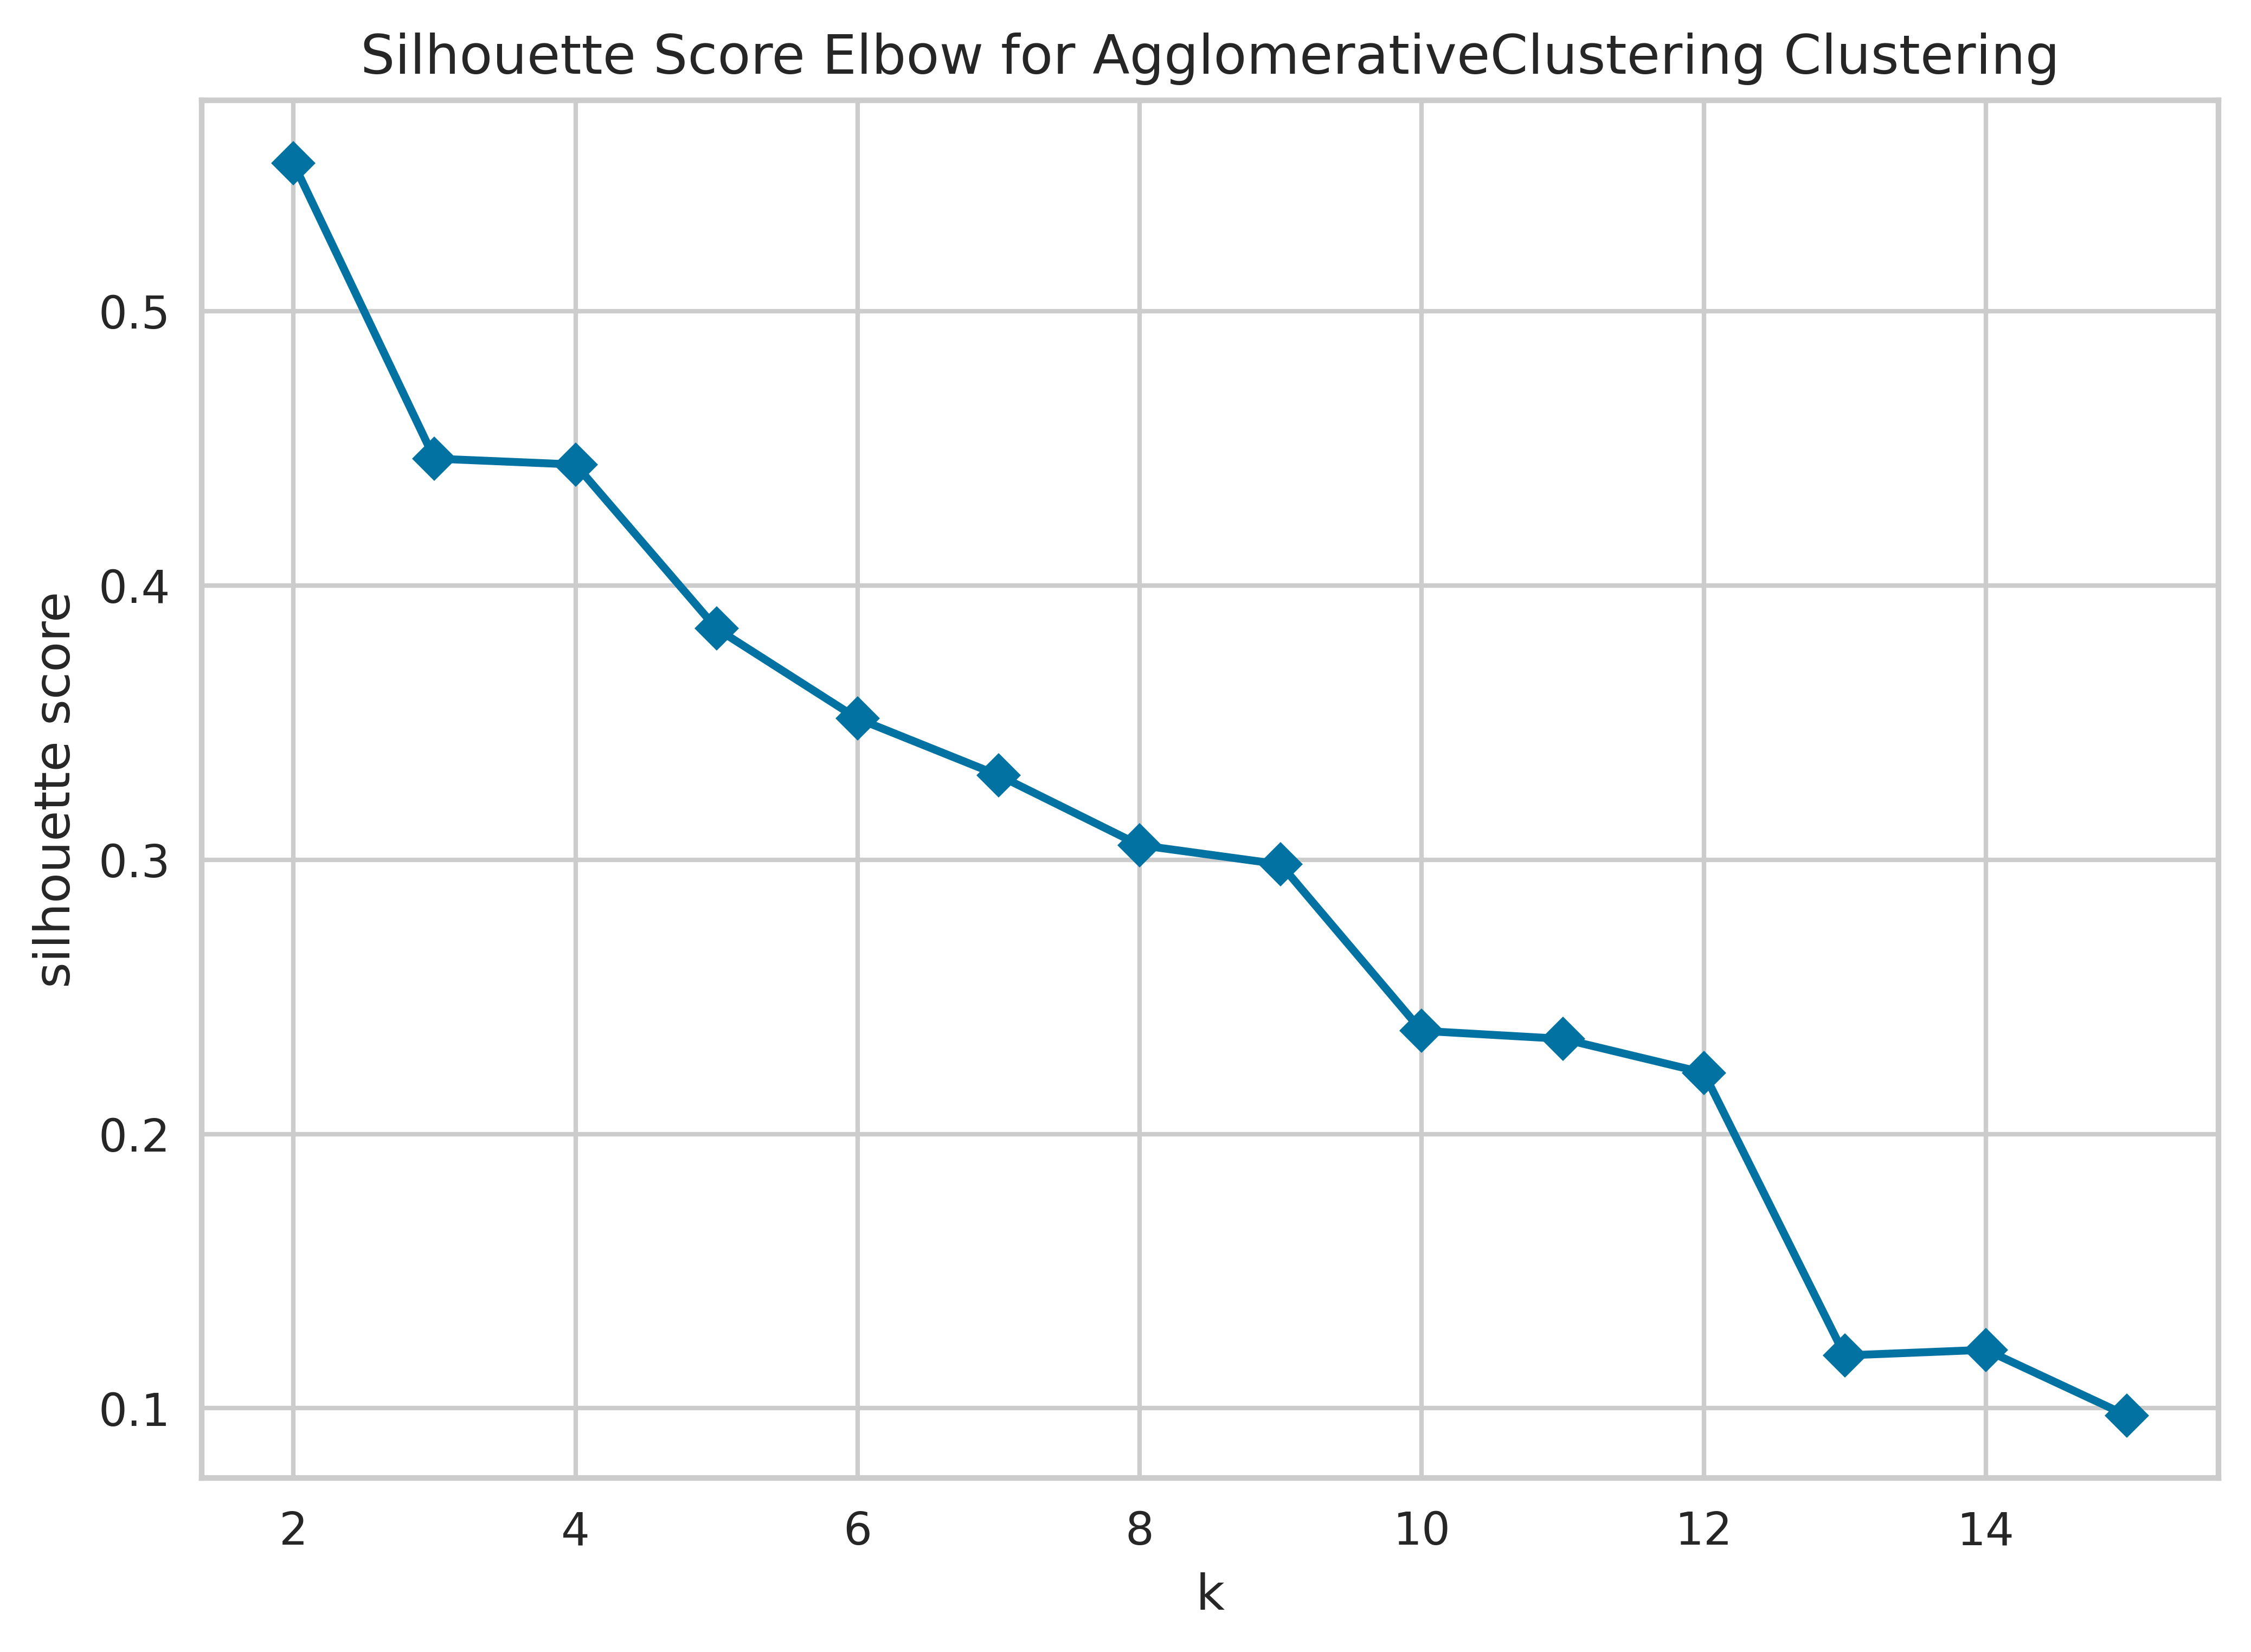

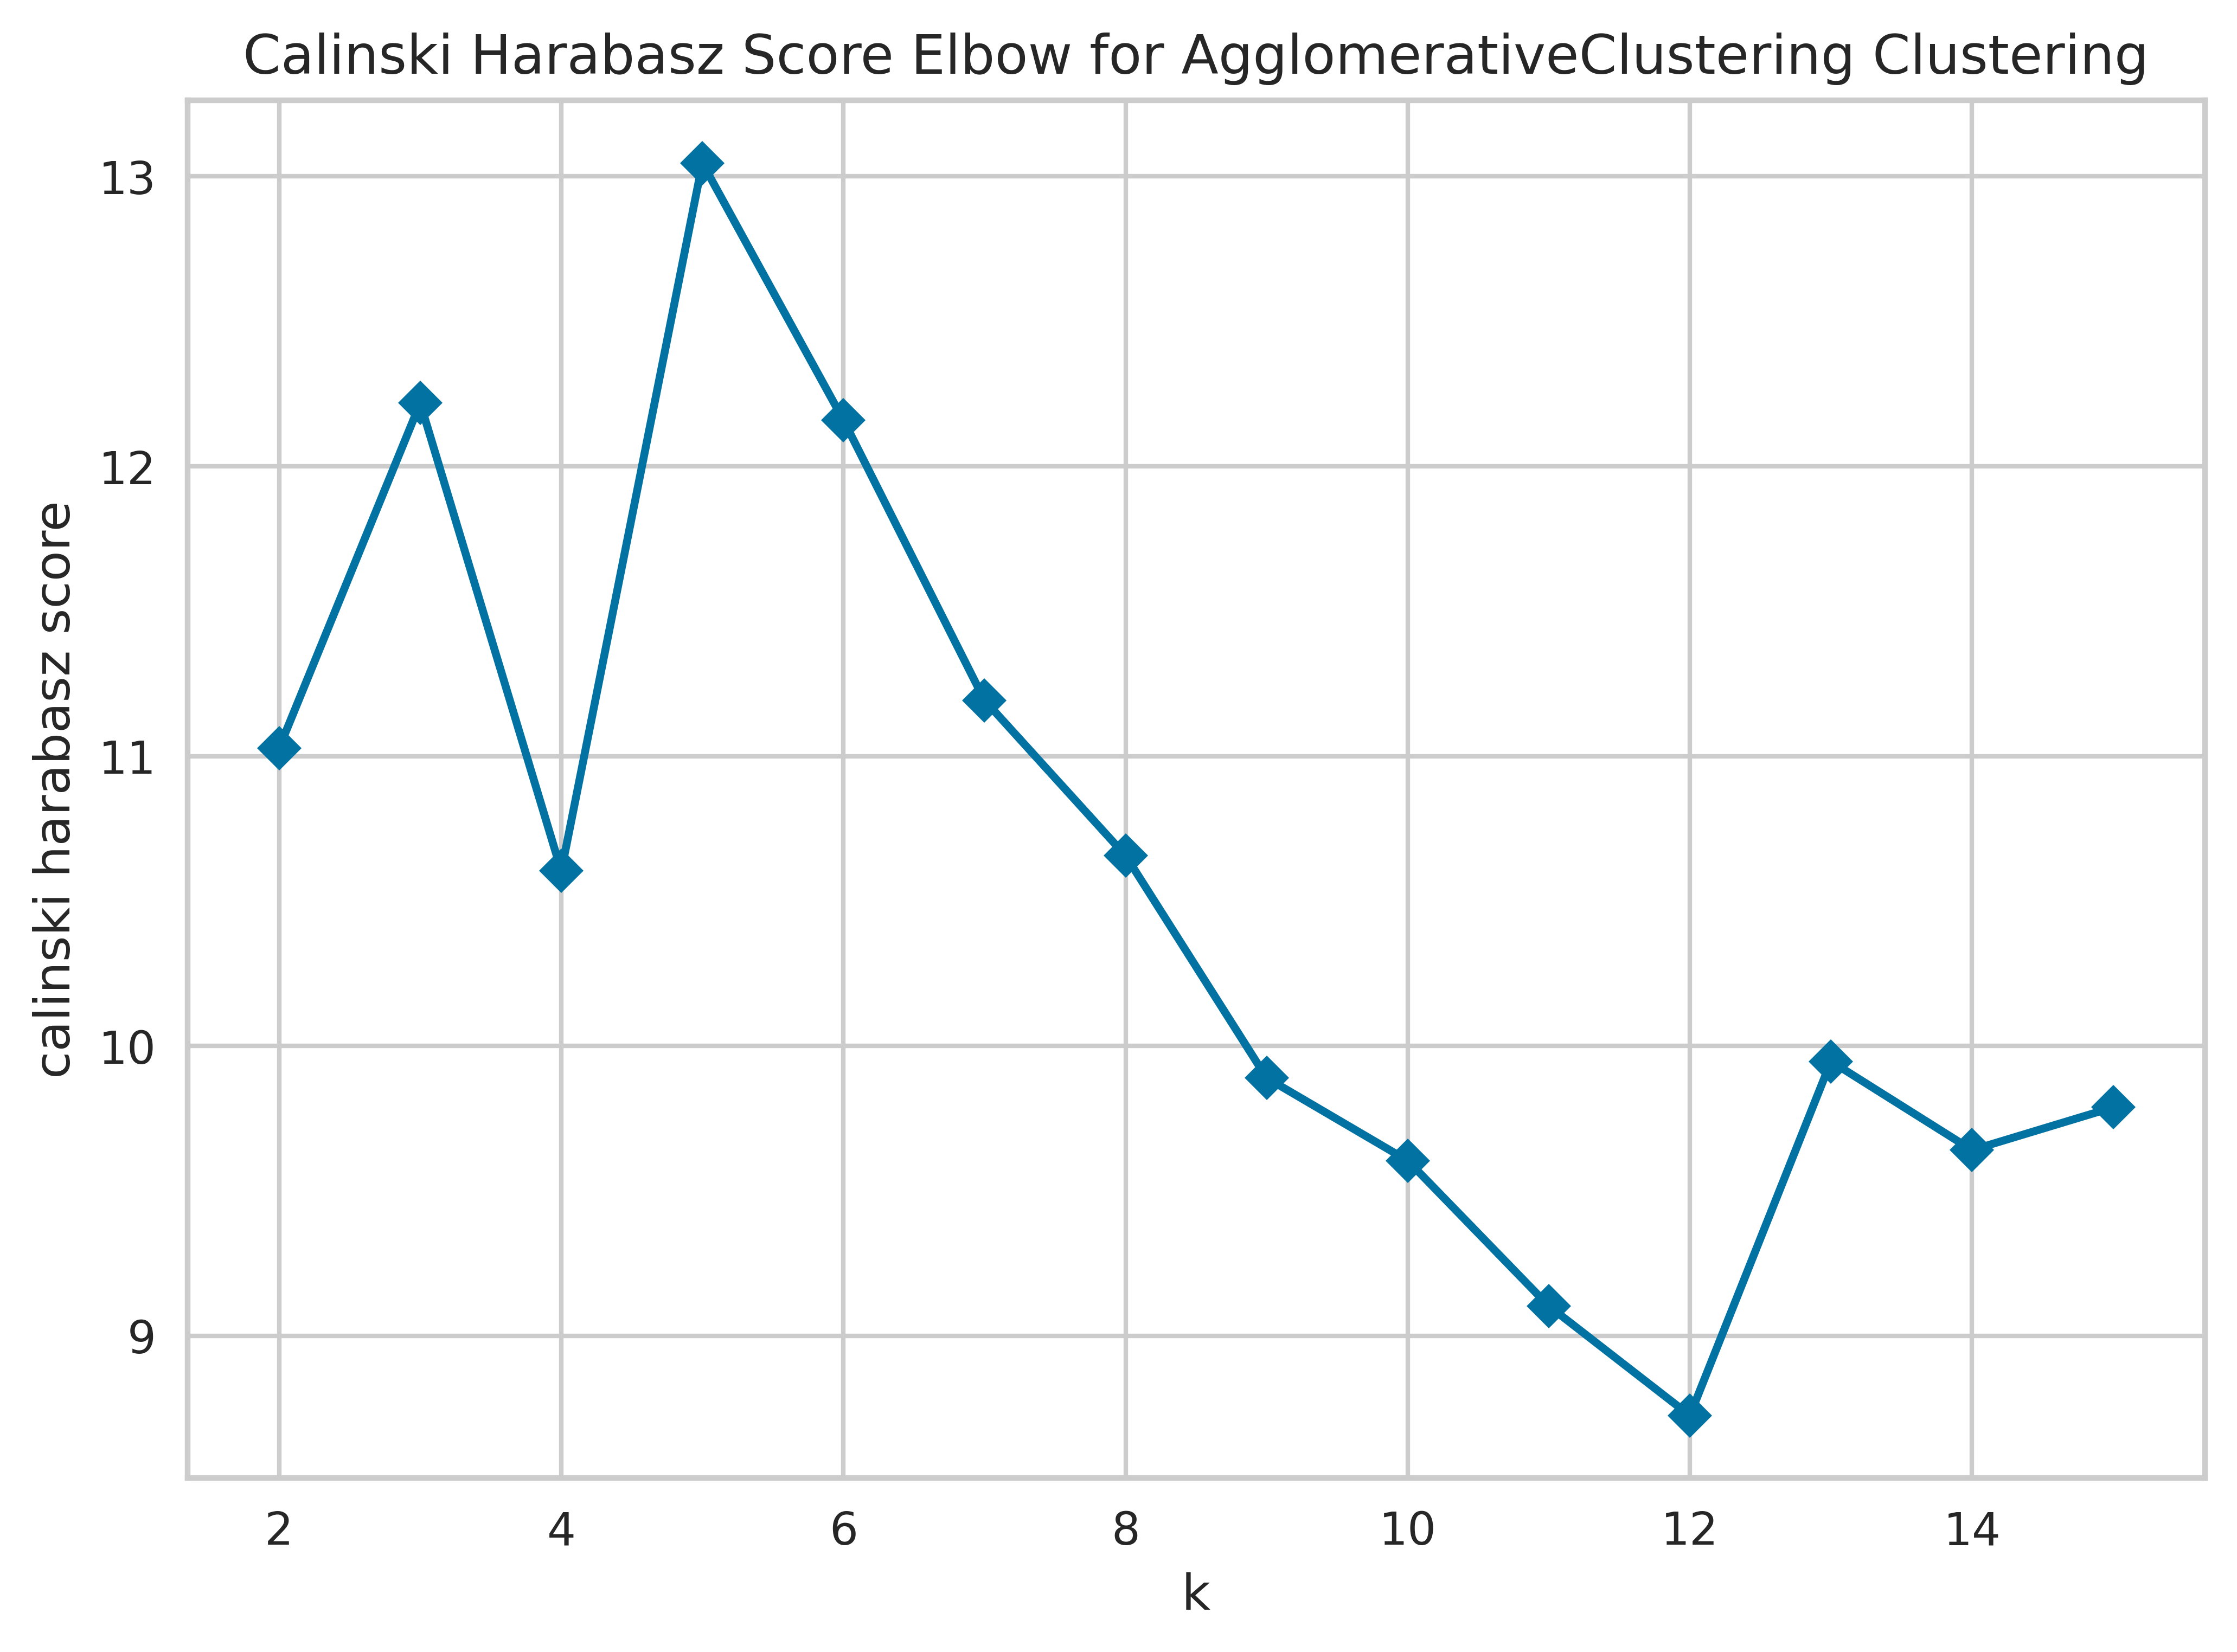

In [14]:
model = AgglomerativeClustering(metric="euclidean", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(mean_physical_space_embs.loc[oe_targets])
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(mean_physical_space_embs.loc[oe_targets])
ax = visualizer.show()

The above plots indicate that the data is best divided into 11 clusters as this maximizes the Calinski-Harabsz score and reaches a local optima of the Silhouette score. Thus, we focus at the solution consisting of 11 clusters.

In [29]:
oe_targets=list(oe_targets)

model = AgglomerativeClustering(n_clusters=18, metric="euclidean", linkage="complete")
phy_space_cluster_labels = model.fit_predict(mean_physical_space_embs.loc[oe_targets])
phy_space_clusters = pd.DataFrame(
    phy_space_cluster_labels,
    index=mean_physical_space_embs.loc[oe_targets].index,
    columns=["cluster"],
)
lut = dict(
    zip(
        list(np.unique(phy_space_cluster_labels)),
        [
            "palevioletred",
            "tab:red",
            "tab:green",
            "gold",
            "tab:orange",
            "tab:cyan",
            "tab:purple",
            "tab:pink",
            "tab:olive",
            "olivedrab",
            "tab:brown",
            "tab:blue",
            "tab:pink",
            "tab:green",
            "gray",
            'tab:olive',
            'b',
            'lightsteelblue',
            'blueviolet'
        ],
    )
)
phy_space_colors = pd.Series(
    phy_space_cluster_labels,
    index=mean_physical_space_embs.loc[oe_targets].index,
).map(lut)

In [30]:

mean_phy_space_embs_dist = pd.DataFrame(
    squareform(pdist(mean_physical_space_embs.loc[oe_targets])),
    index=mean_physical_space_embs.loc[oe_targets].index,
    columns=mean_physical_space_embs.loc[oe_targets].index,
)

linkage = hc.linkage(squareform(mean_phy_space_embs_dist), method="complete")

ax = sns.clustermap(
    mean_phy_space_embs_dist,
    figsize=[14, 12],
    row_linkage=linkage,
    col_linkage=linkage,
    cmap="gray",
    row_colors=np.array(phy_space_colors.loc[mean_phy_space_embs_dist.index]),
    col_colors=np.array(phy_space_colors.loc[mean_phy_space_embs_dist.index]),
    dendrogram_ratio=0.1,
    cbar_pos=(0.04, 0.88, 0.03, 0.1),
    cbar_kws={"shrink": 3, "label": "Euclidean\ndistance"},
)
ax.ax_heatmap.set_yticklabels(
    ax.ax_heatmap.get_ymajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
ax.ax_heatmap.set_ylabel("")
ax.ax_heatmap.set_xlabel("")
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xmajorticklabels(),
    fontsize=15,
    fontweight="bold",
)

ax.ax_cbar.set_ylabel("Euclidean\ndistance", size=15, weight="bold")
ax.ax_cbar.yaxis.set_label_position("left")
# plt.tight_layout()
plt.savefig('geneHeatmap_excludeCompound.jpg')
plt.show()

In [13]:
mean_phy_space_embs_dist.shape

(97, 97)

In [47]:
os.getcwd()

'/home/xinyiz/image2reg/notebooks/jump/ko_embedding'

In [31]:
from scipy.cluster.hierarchy import fcluster

num_clusters = 15  # You can set this based on your requirement
clusters = fcluster(linkage, num_clusters, criterion="maxclust")

# Map cluster indices to genes
clustered_genes = pd.DataFrame({
    "Gene": mean_phy_space_embs_dist.index,
    "Cluster": clusters
}).sort_values("Cluster")

# Print genes in each cluster
allg=''
for cluster_id in range(1, num_clusters + 1):
    genes_in_cluster = clustered_genes[clustered_genes["Cluster"] == cluster_id]["Gene"].tolist()
    out=''
    for g in genes_in_cluster:
        out+=g+', '
        allg+=g+', '
    print(f"Cluster {cluster_id}: {out}")

Cluster 1: CREB1, 
Cluster 2: CENPE, 
Cluster 3: BAX, BUB1, 
Cluster 4: MCM5, 
Cluster 5: PLCG1, FN1, MDK, PLK1, MAPK7, RELB, CDC6, MMP2, TGFB1, NOTCH3, LOXL4, HSPA1B, IGF2, CDC42, KIF15, BRAF, LRP1, KIF4A, CD40, PIK3R2, CCNB2, TIMP1, RHOA, DHRS2, ATF4, CCNF, 
Cluster 6: JUN, PRKCA, CKS2, BCL2L11, SREBF1, YWHAQ, 
Cluster 7: TSC2, IRF7, CYBA, PAK2, TP73, FOS, MYC, MSH2, TINAGL1, ALOX5, KRT8, SKP2, GTSE1, MCM4, BMP4, CCNB1, NEK2, INHBA, KIF23, SMO, NCOR2, GLI1, HK2, MYH9, GLI2, TONSL, WWTR1, FEN1, MCM7, KPNA2, CDK14, TGM2, TUBB6, CCND2, NCF2, IRAK4, KIF2C, E2F1, CASP8, UBE2S, PLCB2, CDCA3, FOXO1, TRIB3, TTK, KLK6, TPM1, 
Cluster 8: CEBPA, RPS6KB1, 
Cluster 9: RRM2, UBE2C, 
Cluster 10: MCM3, 
Cluster 11: TNC, WEE1, 
Cluster 12: HRAS, MYBL2, 
Cluster 13: TRAF2, AXL, 
Cluster 14: FKBP4, 
Cluster 15: CCNE1, 


In [38]:
np.savetxt('genes_excludeCompound.txt',np.array(clustered_genes['Gene']).astype('str'),fmt='%s')

In [35]:
clustered_genes['Gene'].astype('str')

48    CREB1
87    CENPE
59      BAX
42     BUB1
46     MCM5
      ...  
51    MYBL2
92    TRAF2
2       AXL
49    FKBP4
66    CCNE1
Name: Gene, Length: 97, dtype: object

In [15]:
cluster_dict = {}
for cluster_label in np.unique(phy_space_clusters.cluster):
    cluster_dict[cluster_label] = list(
        np.array(list(phy_space_clusters.index))[
            phy_space_clusters.cluster == cluster_label
        ]
    )
for k, v in cluster_dict.items():
    print("Cluster {}: {}".format(k, v))
    print("")

Cluster 0: ['RHOA', 'SMO', 'WWTR1', 'SREBF1', 'FOXO1', 'MYD88', 'DIABLO']

Cluster 1: ['FGFR3', 'PRKCE', 'PIK3R2', 'TRAF2', 'SRC', 'MOS', 'AKT1S1']

Cluster 2: ['MAP3K2', 'CDC42', 'BRAF', 'RAF1', 'MAP3K9']

Cluster 3: ['CASP8', 'BCL2L11']

Cluster 4: ['MAPK7', 'MAP3K5', 'RELB', 'MAP2K3']

Cluster 5: ['CREB1', 'IRAK4', 'TSC2', 'ATF4', 'BAX', 'SMAD4']

Cluster 6: ['JUN', 'CEBPA', 'ERG']

Cluster 7: ['CDKN1A']

Cluster 8: ['HRAS']

Cluster 9: ['ELK1', 'E2F1']

Cluster 10: ['GLI1', 'CXXC4', 'PRKACA']



The output above shows the 11 prominent gene clusters that we identified by clustering the physical space embeddings. A gene ontology analysis indicates the biological meaningfulness of the identified clusters.